In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
from scipy.stats.stats import pearsonr   
import seaborn as sns
import pandas as pd
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200

In [5]:
def lhs(cons: float, x0: float, gamma: float = 1, r: float = 0) -> float:
    return (gamma * (1+r))*(cons ** 2 / x0) ** 2

def rhs(cons: float, gti: float, ft: float) -> float:
    return 1 - (ft * cons) / (gti - cons)

def bisection(x0: float, gti: float, ft:float, gamma: float, r: float = 0, err: float = 1e-2) -> float:
    # Define the left and right hand sides of the equations
    diff = lambda a: rhs(a, gti, ft) - lhs(a, x0, gamma, r)

    # Initial guess at the next options for
    max_val = gti / (1+ft)
    x = [0, max_val / 2, max_val]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])

        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [116]:
def graph_simulation(df, params, start=0, stop=None):
    fig, axs= plt.subplots(ncols=2, nrows=5)
    stop = stop if stop is not None else df.shape[1]-1
    income = df.w * df.n + df.b/(1+params['inflation']) + params['interest']*df.k
    investment = (1 - df.loc[:,'gt']) * income
    # Household
    axs[0,0].plot(df.c[start:stop], label='c')
    axs[0,0].plot(df.b[start:stop], label='b')
    axs[0,0].set_title('Log Consumption & Bonds')
    axs[0,0].set_yscale('log')
    axs[0,0].legend()
    axs[0,1].plot(df.ft[start:stop])
    axs[0,1].set_title('Utility of Bonds')
    
    # Labour Market
    axs[1,0].plot(df.n[start:stop])
    axs[1,0].set_title('Log Labour')
    axs[1,0].set_yscale('log')
    axs[1,1].plot(df.w[start:stop])
    axs[1,1].set_title('Log Wages')
    axs[1,1].set_yscale('log')
    
    # Investment Rate
    axs[2,0].plot(income[start:stop])
    axs[2,0].set_title('Income')
    axs[2,0].set_yscale('log')
    axs[2,1].plot(100*(1-df.loc[:,'gt'][start:stop]), label = r'Investment [%]')
    axs[2,1].set_title('Investment [% of income]')
    
    # Capital Market
    axs[3,0].plot(df.k[start:stop], label='k')
    axs[3,0].set_title('Log Capital')
    axs[3,0].set_yscale('log')
    #axs[3,0].plot(investment, color='red', label='inv')
    axs[3,0].legend(ncol=2)
    
    axs[3,1].plot(df.q[start:stop], label = 'Return to Capital')
    axs[3,1].set_title('Log Return to Capital')
    axs[3,1].axhline(params['interest'], color='red', linewidth=0.5, label='Interests rate')
    axs[3,0].set_yscale('log')
    axs[3,1].legend()
    
    # News
    axs[4,0].plot(df.news[start:stop])
    axs[4,0].set_title('News')
    
    axs[4,1].plot(df.b[start:stop]/df.c[start:stop])
    axs[4,1].axhline(0, color='red')
    axs[4,1].set_yscale('log')
    axs[4,1].set_title('Bond/Consumption Ratio')
    
    fig.set_size_inches(20, 10)
    fig.tight_layout()
    plt.show()

In [6]:
def smoothing(x:float, x0:float, theta:float, xmin:float, xmax:float):
    """ Project the input onto a given scale via tanh """
    return 0.5 * (np.tanh(theta*(x-x0))*(xmax-xmin)+xmax+xmin)

<font size="5">
    Steps of the algorithm that are implemented
    \begin{eqnarray}
        \xi_t &=& \eta_z \xi_{t-1} + \sqrt{1-\eta_z^2}\mathcal{N}(0,\sigma_z) \\
        z_t &=& \bar{z}e^{\xi_t} \\
        I_t &=& w_{t-1}n_{t-1} + \frac{b_{t-1}}{1+r_{CB}} + q_{t-1}k_{t-1} \\
        k_t &=& (1-\delta)k_{t-1} + (1-G_t)I_t \\
        c_t &=& \textrm{via bisection in overleaf, given k, G_t, I_t} \\
        n_t &=& \frac{c_t^2}{4k_tz_t^2} \\
        b_t &=& (G_tI_t - c_t)(1 + r_{CB}) \\
        w_t &=& \frac{1}{2}\frac{c_t}{n_t} \\
        q_t &=& 2 z \sqrt{\frac{n_t}{k_t}} \\
    \end{eqnarray}
</font>

<font size="5">
    Generating the news. First, we take a generic tanh normalisation function
    \begin{equation}
        H(x, x_0, x_{min}, x_{max}) = \frac{1}{2}\left(\tanh(\theta(x-x_0))+x_{max}+x_{min}\right)
    \end{equation}
    <br>
    We define the news in each period to be 
    \begin{eqnarray}
        info_t &=& \tanh\left(\beta_c\left[\frac{c_t}{c_{t-1}}-1\right]\right) + \tanh\left(\beta_q\left[q_{t}-r_{CB}\right]\right) \\
        N_t &=& \tanh\left(\theta_n\left[\beta_{pers}N_{t-1} + (1-\beta_{pers})info_t + \xi_t\right]\right)
    \end{eqnarray}
    <br>
    This converts into a consumption rate $G_t$ and bond utility modifier $F_t$ via
    \begin{align}    
        G_t &= H(-N_t, 0, G_{min}, G_{max}) \\
        F_t &= H(-N_t, 0, F_{min}, F_{max}) \\
    \end{align}
</font>

In [94]:
def step(t: float, x: np.ndarray, p: dict):
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, gt_, ft_, news_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
        
    # Income and Investment
    income = w_ * n_ + b_ / (1 + p['inflation']) + q_ * k_
    
    # Capital Markets
    k = (1 - p['depreciation']) * k_ + income * (1 - gt_)

    # Household decision
    x0 = z * np.sqrt(2 * k)
    c = bisection(x0, gt_ * income, ft_, p['gamma'], p['interest'])
    n = (c ** 2) / (4 * k * (z ** 2))
    b = (gt_ * income - c) * (1 + p['interest'])
    
    # Firm decisions
    w = 0.5 * c / n
    q = 2 * z * np.sqrt(n/k)

    # Investment rate and savings decision
    xin = np.random.normal(0, p['sigmaN'])
    info = 0.5 * (np.tanh(p['n_cons']*(c/c_ - 1)) + np.tanh(p['n_return']*(q - p['interest'])))
    news = np.tanh(p['n_theta'] * (p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin))
    #if t > 440 and t< 600:
    #    news = .7
    gt = smoothing(-news, p['g_0'], p['g_theta'], p['g_min'], p['g_max'])
    ft = smoothing(-news, p['f_0'], p['f_theta'], p['f_min'], p['f_max'])
    #if t > 300 and t < 400:
    #    ft = 1e-5
    
    return z, c, n, b, w, k, q, gt, ft, news, xiz, xin

def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'gt', 'ft', 'news', 'xiz', 'xin']
    return pd.DataFrame(x, columns=cols)

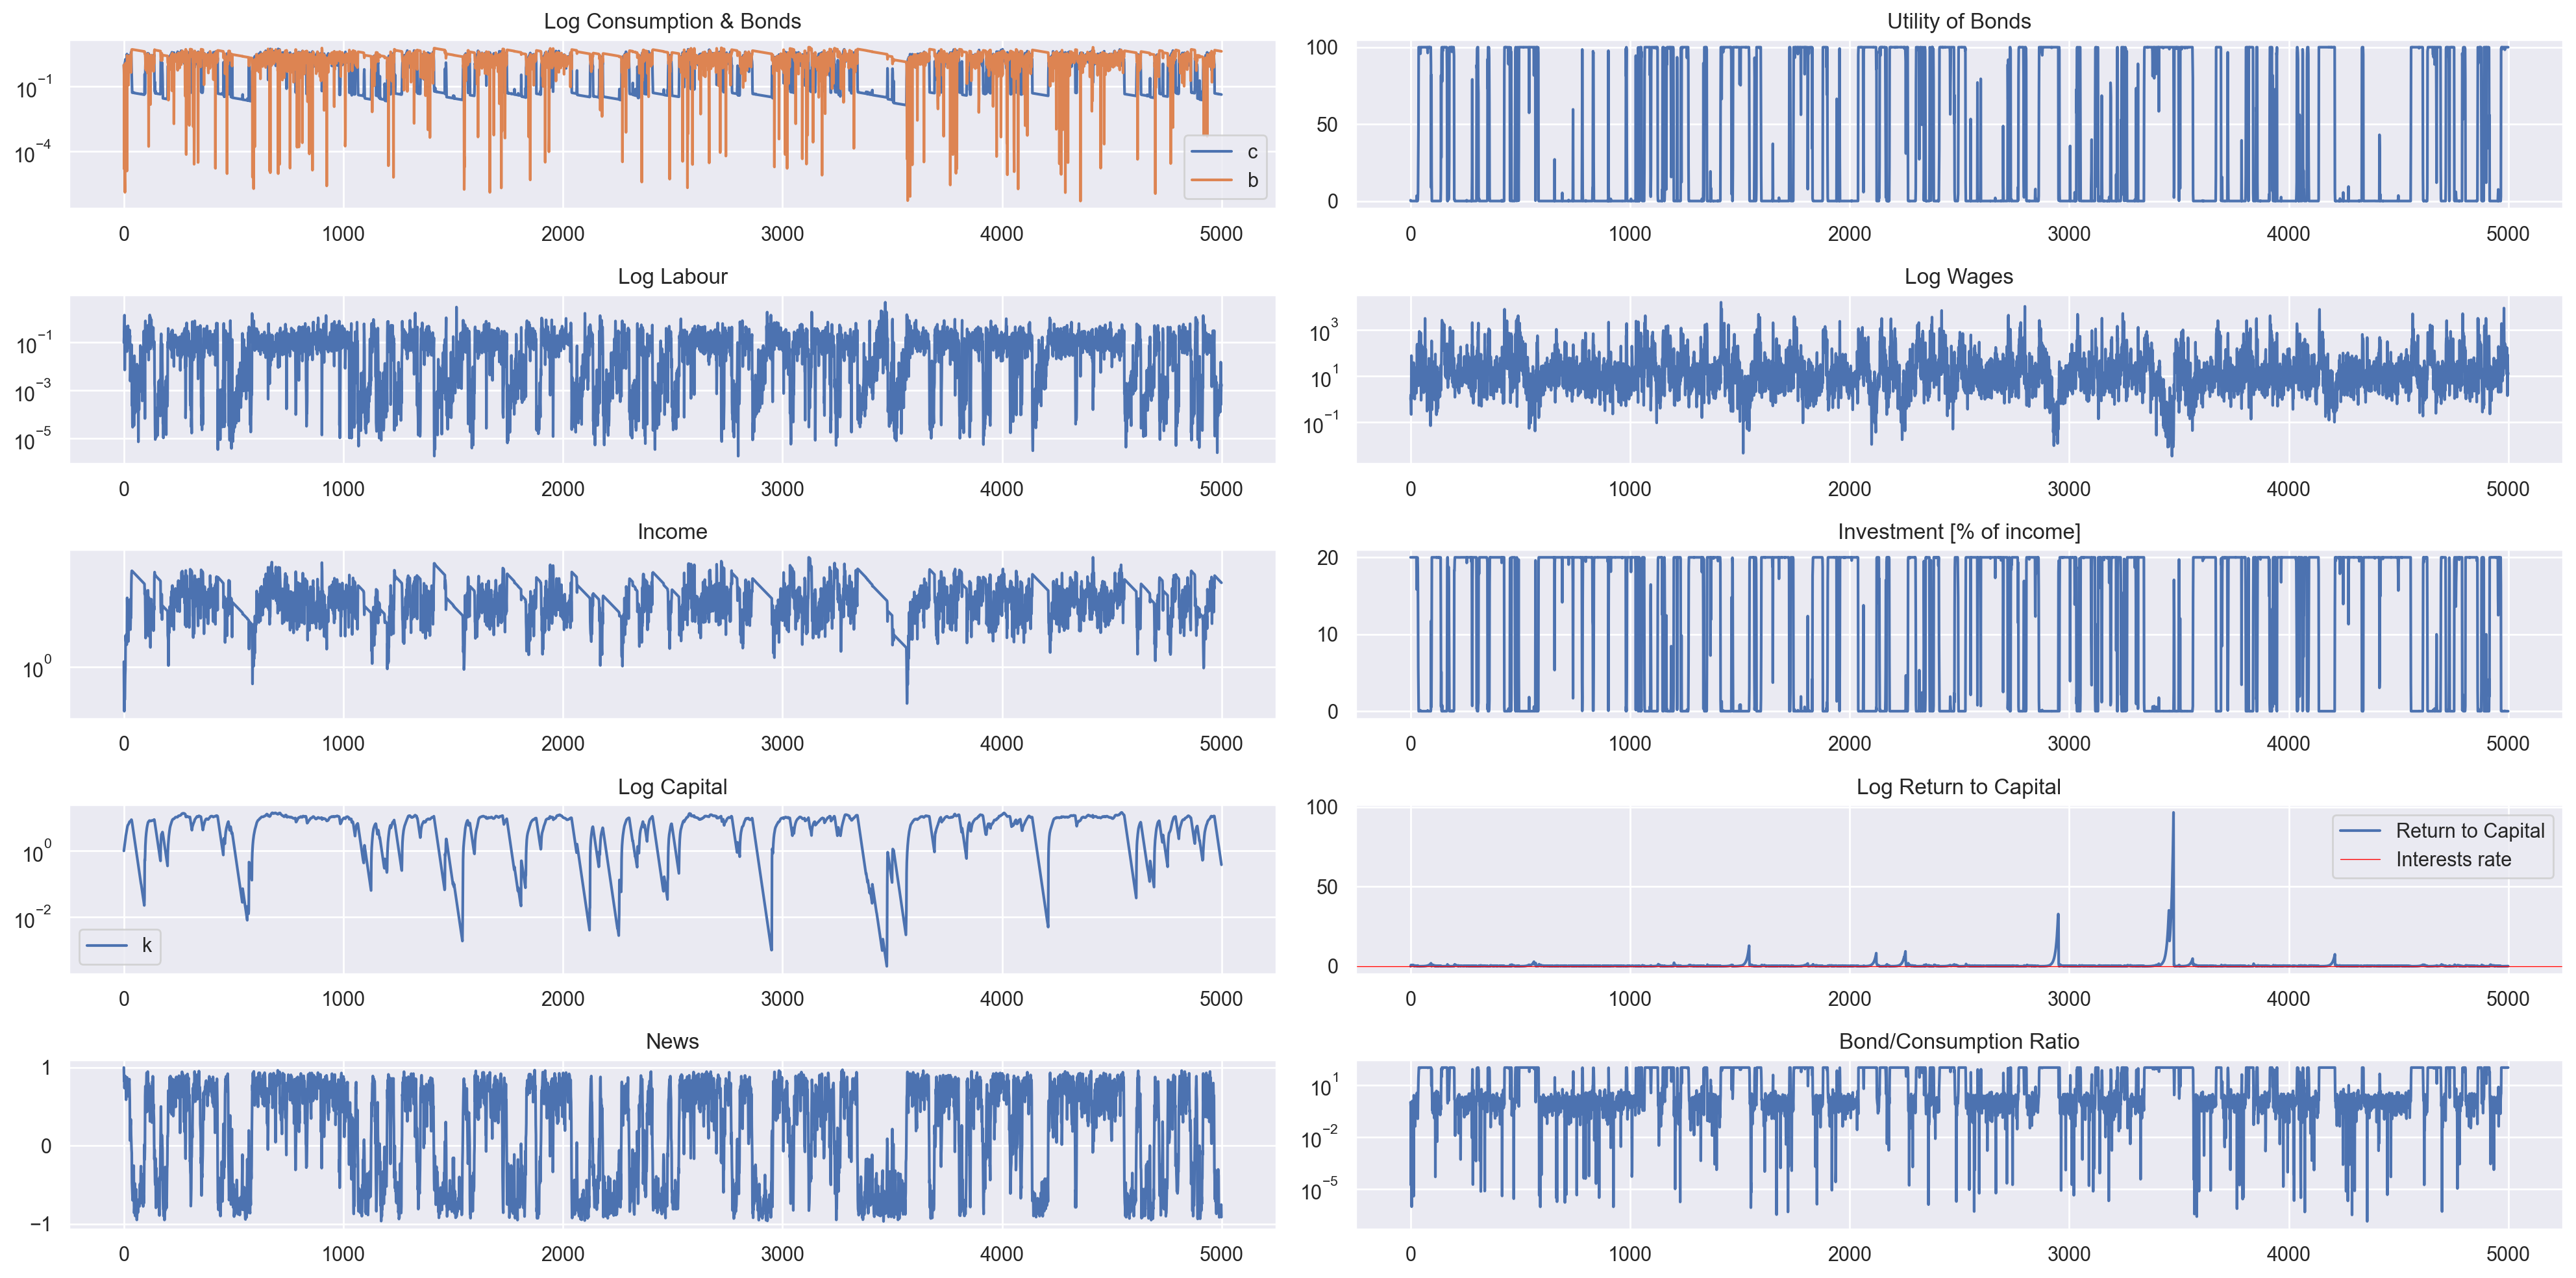

In [117]:
# SET PARAMETERS
params = dict(
    etaZ=0.1, sigmaZ=0.8, zbar=1, sigmaN=0.2, #zbar=noE
    inflation=0.01, interest=0.001, depreciation=0.1,
    g_0=0.0, g_min=0.8, g_max=1.0, g_theta=10,
    f_0=0.1, f_min=0.0, f_max=100, f_theta=10,
    n_persistence=0.8, n_theta=1.6, n_cons=1, n_return=0,
    gamma=1
)

# INITIAL VALUES
start = dict(z=1, c=1, n=0.1, b=1, w=1, k=1, q=0, gt=0.8, ft=.5, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 5e3
np.random.seed(40)

df = simulate(start, params, T)
graph_simulation(df, params, 0, int(5e3))

<font size="5">
    Observations from parameterisations:
</font>

In [106]:
params = dict(
    etaZ=0.1, sigmaZ=0.8, zbar=1, sigmaN=0.2, #zbar=noE
    inflation=0.01, interest=0.01, depreciation=0.1,
    g_0=0.0, g_min=0.8, g_max=1.0, g_theta=10,
    f_0=0.1, f_min=0.0, f_max=100, f_theta=10,
    n_persistence=0.8, n_theta=1.6, n_cons=10, n_return=0,
    gamma=1
)

We achieve the following:
1. Bi-stable news between -1 and +1
2. For negative news, Investment % -> 0, Capital declines
3. <font color=red>Income increases during recessions and decreases/stable during neutral periods</font>
4. Labour decreases sharply in recession, and then slowly recovers
5. Bond to consumption increases sharply during recessions (negative news and decreasing capital)
6. Return to capital is inverse to capital levels, at equilibrium with ~10% return, but crazy upward oscillations in crisis
7. <font color=red>Wages jump up during crises</font>
8. Consumption is stable with expected drops during crises

Parameter effects (taking the above parameter set as baseline these are the effects)

| Parameter | Effects | Values | Description |
| --- | --- | --- | --- |
| $\eta_z$ | Qualitative | 0.2 | Inverse of tech schock timescale (autocorr)|
| $\sigma_z$ | Qualitative | 0.8 | How extreme shocks are (adds noise) |
| $\bar{z}$ | Qualitative | 1.0 | Technology level (no effect) |
<br>
| Inflation | Phenomenology | 0.01 | 10% makes news more bistable, fewer transitions, deeper recessions, 1e-3 no effect (High inflation change)|
| Interest | Phenomenology | 0.01 | 10% makes the recessions shorter (non-bistable news) and increases income in recessions drastically, 1e-3 decreasing income in recessions|
| Depreciation | Qualitative | 0.1 | 1% makes capital less sensitive, 30% makes labour jump and income jump more drastically|
| $\gamma$ | Qualitative | 1.0 | Doesn't seem to have any effect|
<br>
| $G_0$ | Qualitative | 0.0 | Change to -0.1, 0.1 makes almost no difference|
| $G_{min}$ | Phenomenology | 0.8 | Change to 0.6 leads to long-term negative growth, 0.1 makes almost no difference, change to 0.9 leads to b>c for all t|
| $G_{max}$ | Phenomenology | 1.0 | Change to 0.9 leads to an almost periodic cycling with all desired properties|
<br>
| $F_0$ | Qualitative | 0.1 | Change to 0.0 or 0.3 makes only difference to income |
| $F_{min}$ | Phenomenology | 0.0 | Fmin >0.9 leads to economy declining (probably because still save too much in good times)|
| $F_{max}$ | Phenomenology | 100.0 | 10-> Massive income boosts in recessions, labour rises in recessions, >500 and income no longer grows, >50 phenomena become reasonable |
<br>
| $\beta_{pers}$ | Phenomenology | 0.8 | <0.5 is noise, 0.5<$\beta_{pers}$<.75 super noisy crisis, >0.8 bi-stability|
| $\theta_{n}$ | Phenomenology | 1.6 | <1.5 noise in news, >2.0 super bi-stable, few switches|
| $\beta_{c}$ | Qualitative | 10 | Seems to have no effect when changed between 1, 10, 100|
| $\beta_{q}$ | Phenomenology | 0 | >10 reduces range of return to capital, makes system stick in good news, hence narrowing all other variables' range|



In [613]:
g = 4.12691520115423
gamma = 1.0
r = 0.01
x0 = 0.3195333487091828
nx = 10000
x = np.linspace(-5,5,nx)

ut.plot_settings()
fig, ax = plt.subplots(figsize = (6,6))

# AXES
ax.axhline(0, color='k', linewidth=.5)
ax.axvline(0, color='k', linewidth=.5)

# RHS & LHS
ax.plot(x, model.rhs(x, g, gamma, r), color = 'r')
ax.plot(x, model.lhs(x, x0), color = 'b')

# Solution point
cons = model.bisection(x0, g, gamma, r, 1e-4)
g_ = model.rhs(cons, g, gr)

# Key Sections
ax.axvline(g, linestyle='--', color='k')
ax.axvline(g/2, linestyle='--', color='k')
ax.axvline(cons, linewidth=1, color='k')

# Mark the Solution
circle_rad = 3  # This is the radius, in points
ax.plot(cons, g_, 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate('Unique\nSolution', xy=(cons, g_), xytext=(-2, -2),
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

# Mark the consumption = 0 point
circle_rad = 3  # This is the radius, in points
ax.plot(0, 1/(1+r), 'o', ms=circle_rad * 2, mec='k', mfc='none', mew=1)
ax.annotate(r'$\frac{1}{1+r_t}$', xy=(0, 1/(1+r)), xytext=(-5, -1), fontsize=20,
            arrowprops=dict(width=1, color='k', headwidth=0, shrinkB=circle_rad * 1.2)
)

ax.set_ylim([-10,10])
ax.set_ylim([-5.1,5.1])
ax.set_xlabel(r'$c_t$')
ax.set_ylabel(r'$f(c_t)$')

plt.savefig('figures/test.pdf', format='pdf', bbox_inches = 'tight', transparent=True)

NameError: name 'ut' is not defined

In [ ]:
z = 1
#g = 5
gr = 1

fig, ax = plt.subplots(1,1,figsize = (6,6))

capital = np.logspace(-3,3,100)

for g in [1,2,5,10]:
    cons = []
    for k in capital:
        cons.append(bisection(z*np.sqrt(2*k),g,gr, 1e-4))
    ax.plot(np.log(capital), np.log(cons), label= r'$g_t = $' + str(g))
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.legend()
#plt.plot(capital, g-np.asarray(cons))
plt.savefig('/Users/fedemoro/Desktop/sols.eps', format='eps',bbox_inches = 'tight')#,transparent=True)

In [ ]:
k_ratio = np.linspace(-0.1,0.1,11) + 1
n_ratio = np.linspace(-0.1,0.1,5) + 1

def signal(k_r,n_r, alpha=0.5):
    return (k_r**alpha)*(n_r**(1-alpha))

fig, ax = plt.subplots()
for n_r in n_ratio:
    ax.plot(k_ratio, signal(k_ratio,n_r), label="{:.2f}".format(n_r))
ax.legend(title="Labour ratio")
ax.set_xlabel("Capital Ratio (kt / kt-1)")
ax.set_ylabel("Signal")
fig.set_size_inches(10, 4)
fig.tight_layout()
plt.show()